In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import ElasticNet
# from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

from utils_data_structures import col_prefixes

In [2]:
grouped_df = pd.read_csv('sorare_data/large_grouped_sorare_data.csv')

grouped_df = grouped_df.fillna(0.0)
# grouped_df = pd.get_dummies(grouped_df, columns=['Current_Club'])

print(grouped_df['So_5_Scores_9'].isna().sum())
grouped_df['Position'].unique()

0


array(['Forward', 'Defender', 'Midfielder', 'Goalkeeper', 'Coach'],
      dtype=object)

In [3]:
midfielders_df = grouped_df[grouped_df['Position'] == 'Midfielder']
midfielders_df = midfielders_df.drop(columns=['Display_Name', 'First_Name','Last_Name','Player_Number', 'Position', 'Current_Club'])

In [4]:
midfielders_df.dtypes.value_counts()

float64    308
int64        4
Name: count, dtype: int64

In [5]:
# Create X and y and split into training and testing sets
target_column = 'So_5_Scores_9'
columns_to_drop = [f'{col}_9' for col in col_prefixes]

X = midfielders_df.drop(columns=columns_to_drop)
y = midfielders_df[target_column]


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Initialize the XGBoost regressor
xgb_model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=6, random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
y_pred_xgb_clipped = np.clip(y_pred_xgb, 0, 100)
mse = mean_squared_error(y_test, y_pred_xgb_clipped)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')
r2 = r2_score(y_test, y_pred_xgb_clipped)
print(f'r2: {r2}')

RMSE: 16.948904947775183
r2: 0.5051755201962922


In [8]:
# Initialize the LightGBM regressor
lgbm_model = lgb.LGBMRegressor(
    boosting_type='gbdt',  # Gradient boosting decision tree
    n_estimators=400,      # Number of boosting rounds (trees)
    learning_rate=0.01,     # Step size shrinkage
    max_depth=10,          # Unlimited depth of trees (-1 means no limit)
    random_state=42,        # For reproducibility
)
# 

# Train the model
lgbm_model.fit(X_train, y_train)
# Make predictions
y_pred_lgbm = lgbm_model.predict(X_test)

# Evaluate
y_pred_lgmb_clipped = np.clip(y_pred_lgbm, 0, 100)
mse = mean_squared_error(y_test, y_pred_lgmb_clipped)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')
r2 = r2_score(y_test, y_pred_lgmb_clipped)
print(f'r2: {r2}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8960
[LightGBM] [Info] Number of data points in the train set: 4005, number of used features: 191
[LightGBM] [Info] Start training from score 18.861928
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
RMSE: 16.404503014983995
r2: 0.53645271266115


In [9]:

# Initialize ElasticNet
elastic_model = ElasticNet(alpha=0.05, l1_ratio=0.9, random_state=42)

# Train the model
elastic_model.fit(X_train, y_train)

# Make predictions
y_pred_en = elastic_model.predict(X_test)

# Evaluate
y_pred_en_clipped = np.clip(y_pred_en, 0, 100)
mse = mean_squared_error(y_test, y_pred_en_clipped)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')
r2 = r2_score(y_test, y_pred_en_clipped)
print(f'r2: {r2}')

RMSE: 16.557236559555438
r2: 0.5277808489632703


c:\Users\mttca\nwuai\course_materials\class_work\projects\Project_2\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.039e+05, tolerance: 2.482e+02
  model = cd_fast.enet_coordinate_descent(


In [10]:
with open('sorare_models/midfielders_xgb_model.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)
    print("XGB Model saved successfully!")
with open('sorare_models/midfielders_lgbm_model.pkl', 'wb') as file:
    pickle.dump(lgbm_model, file)
    print("LGBM Model saved successfully!")

with open('sorare_models/midfielders_elastic_model.pkl', 'wb') as file:
    pickle.dump(elastic_model, file)
    print("Elastic Model saved successfully!")

print("Models saved successfully!")

XGB Model saved successfully!
LGBM Model saved successfully!
Elastic Model saved successfully!
Models saved successfully!


In [11]:
y_test_df = pd.DataFrame(y_test)
y_test_df['XBG_Predictions'] = y_pred_xgb_clipped
y_test_df['LGBM_Predictions'] = y_pred_lgmb_clipped
y_test_df['EN_Predictions'] = y_pred_en_clipped
y_test_df

,So_5_Scores_9,XBG_Predictions,LGBM_Predictions,EN_Predictions
12518,0.0,2.927118,7.772700,11.886500
6743,0.0,7.204574,7.316146,11.665446
14003,0.0,0.000000,1.817277,4.416207
11538,0.0,0.363359,0.928291,0.532258
9647,49.5,43.818569,38.088046,43.072993
...,...,...,...,...
9439,0.0,0.306454,1.179814,1.060371
10511,0.0,0.000000,0.928291,1.060041
15109,0.0,0.235909,1.236724,1.441868
10567,44.5,37.620243,38.103844,35.986250


In [12]:
y_test_df['Average_Prediction'] = (y_test_df['XBG_Predictions'] + y_test_df['LGBM_Predictions'] + y_test_df['EN_Predictions']) / 3
y_test_df

,So_5_Scores_9,XBG_Predictions,LGBM_Predictions,EN_Predictions,Average_Prediction
12518,0.0,2.927118,7.772700,11.886500,7.528773
6743,0.0,7.204574,7.316146,11.665446,8.728722
14003,0.0,0.000000,1.817277,4.416207,2.077828
11538,0.0,0.363359,0.928291,0.532258,0.607970
9647,49.5,43.818569,38.088046,43.072993,41.659869
...,...,...,...,...,...
9439,0.0,0.306454,1.179814,1.060371,0.848880
10511,0.0,0.000000,0.928291,1.060041,0.662777
15109,0.0,0.235909,1.236724,1.441868,0.971500
10567,44.5,37.620243,38.103844,35.986250,37.236779


In [13]:
y_true = y_test_df['So_5_Scores_9'].to_numpy()
y_pred = y_test_df['Average_Prediction'].to_numpy()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f'RMSE: {rmse}')
r2 = r2_score(y_test, y_pred_en_clipped)
print(f'r2: {r2}')

RMSE: 16.343727611820494
r2: 0.5277808489632703


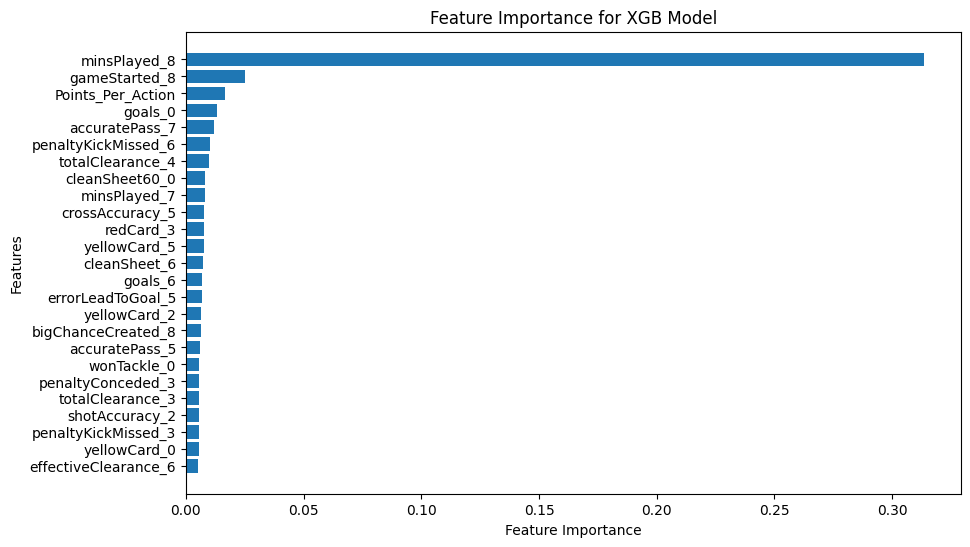

In [14]:

# Get feature importances
importances = xgb_model.feature_importances_

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

top_n = 25  # Number of top features to show
top_features = feature_importance_df.nlargest(top_n, 'Importance')

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance for XGB Model')
plt.gca().invert_yaxis()
plt.show()

In [15]:
epl_teams = pd.read_csv('sorare_data/large_cleaned_sorare_data.csv')

epl_teams = epl_teams.fillna(0.0)

epl_midfielders_df = epl_teams[epl_teams['Position'] == 'Midfielder']

epl_midfielders_df = epl_midfielders_df.reset_index(drop=True)

In [16]:
drop_columns = columns=['Display_Name', 'First_Name','Last_Name','Player_Number', 'Position', 'Current_Club']

columns_to_drop = [f'{col}_9' for col in col_prefixes]
columns_to_drop.extend(drop_columns)

target_column = 'So_5_Scores_9'

X_test_midfielders = epl_midfielders_df.drop(columns=columns_to_drop)
y_test_midfielders = epl_midfielders_df[target_column]

In [17]:
with open('sorare_models/midfielders_xgb_model.pkl', 'rb') as file:
    midfielders_xgb_model_loaded = pickle.load(file)
    print("XGB Model loaded successfully!")
with open('sorare_models/midfielders_lgbm_model.pkl', 'rb') as file:
    midfielders_lgbm_model_loaded = pickle.load(file)
    print("LGBM Model loaded successfully!")
with open('sorare_models/midfielders_elastic_model.pkl', 'rb') as file:
    midfielders_elastic_model_loaded = pickle.load(file)
    print("Elastic Model loaded successfully!")

XGB Model loaded successfully!
LGBM Model loaded successfully!
Elastic Model loaded successfully!


In [18]:
xgb_predictions = midfielders_xgb_model_loaded.predict(X_test_midfielders)
lgbm_predictions = midfielders_lgbm_model_loaded.predict(X_test_midfielders)
elastic_predictions = midfielders_elastic_model_loaded.predict(X_test_midfielders)

xgb_predictions = np.clip(xgb_predictions, 0, 100)
lgbm_predictions = np.clip(lgbm_predictions, 0, 100)
elastic_predictions = np.clip(elastic_predictions, 0, 100)

y_test_midfielders_df = pd.DataFrame(y_test_midfielders)

epl_midfielders_df['sorare_xgb_predictions'] = pd.Series(xgb_predictions)
epl_midfielders_df['sorare_lgbm_predictions'] = pd.Series(lgbm_predictions)
epl_midfielders_df['sorare_elastic_predictions'] = pd.Series(elastic_predictions)

epl_midfielders_df['sorare_predictions'] = epl_midfielders_df[['sorare_xgb_predictions', 'sorare_lgbm_predictions', 'sorare_elastic_predictions']].mean(axis=1)

epl_midfielders_df[['So_5_Scores_9','sorare_xgb_predictions', 'sorare_lgbm_predictions', 'sorare_elastic_predictions']].head(3)

,So_5_Scores_9,sorare_xgb_predictions,sorare_lgbm_predictions,sorare_elastic_predictions
0,12.2,15.692162,36.652014,52.714282
1,35.9,34.603539,30.850191,22.070620
2,0.0,2.209870,1.885614,9.243064


In [19]:
y_true = epl_midfielders_df['So_5_Scores_9'].to_numpy()
y_pred = epl_midfielders_df['sorare_predictions'].to_numpy()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f'RMSE: {rmse}')
r2 = r2_score(y_true, y_pred)
print(f'r2: {r2}')

RMSE: 12.71506796624259
r2: 0.7466700801531061


In [20]:
xgb_scores = cross_val_score(midfielders_xgb_model_loaded, X, y)
lgbm_scores = cross_val_score(midfielders_lgbm_model_loaded, X, y)
elastic_scores = cross_val_score(midfielders_elastic_model_loaded, X, y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8814
[LightGBM] [Info] Number of data points in the train set: 4005, number of used features: 191
[LightGBM] [Info] Start training from score 18.386229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8803
[LightGBM] [Info] Number of data points in the train set: 4005, number of used features: 191
[LightGBM] [Info] Start training from score 18.387278
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

c:\Users\mttca\nwuai\course_materials\class_work\projects\Project_2\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.959e+05, tolerance: 2.419e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\mttca\nwuai\course_materials\class_work\projects\Project_2\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.938e+05, tolerance: 2.449e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\mttca\nwuai\course_materials\class_work\projects\Project_2\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might

In [21]:
print("XGBoost scores:", xgb_scores)
print("Mean XGBoost score:", xgb_scores.mean())

print("LGBM scores:", lgbm_scores)
print("Mean LGBM score:", lgbm_scores.mean())

print("Elastic scores:", elastic_scores)
print("Mean Elastic score:", elastic_scores.mean())

XGBoost scores: [0.50033075 0.49907779 0.56274663 0.53362934 0.54545907]
Mean XGBoost score: 0.5282487153097083
LGBM scores: [0.53274687 0.53909525 0.56876268 0.55861729 0.55559095]
Mean LGBM score: 0.550962608771783
Elastic scores: [0.53346223 0.55112898 0.57496311 0.54402205 0.54077172]
Mean Elastic score: 0.548869616509587


In [22]:
saved_midfielders_df = epl_midfielders_df[['Display_Name', 'First_Name','Last_Name','Player_Number', 'Position', 'Current_Club','So_5_Scores_9','sorare_xgb_predictions', 'sorare_lgbm_predictions', 'sorare_elastic_predictions', 'sorare_predictions']]
saved_midfielders_df.to_csv('sorare_data/predictions/sorare_midfielders_predictions.csv', index=False)